In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Recreation of diagrams from Washington Post article

## Load and filter data 

Note on method from Washington Post:
> Note on methods: ProPublica obtained records for nearly 12,000 defendants in Broward County, Fla., who were assigned a COMPAS score in 2013-2014. ProPublica then determined which defendants were charged with new crimes in the subsequent two years, and made this data set publicly available. We focused on the 5,278 cases involving defendants who are either white or black, and for which a full two years of recidivism information is available. We excluded Hispanic defendants from our analysis because there are not many in this data set. The COMPAS tool also rates defendants on about two dozen other dimensions of risk, including likelihood to commit a violent crime, but here we consider only the overall recidivism score.

Therefore they used data from the file `compas-scores-two-years.csv` (aggregrated data from Compas + criminal history for "general Risk of Recidivism”)

In [136]:
# Load df
df = pd.read_csv("../../data-ProPublica/compas-scores-two-years.csv", parse_dates=["compas_screening_date"])

In [137]:
# Recreate filter from Washington Post article
df = df[
        (df["days_b_screening_arrest"]<=30) 
        & (df["days_b_screening_arrest"]>=-30) 
        & (df["is_recid"]!=-1) 
        & (df["c_charge_degree"]!="O") 
        & ((df["race"]=="African-American") | (df["race"]=="Caucasian")) 
        #& (df["compas_screening_date"]<="2014-04-01") #for correcting filter error from ProPublica
      ].dropna(subset=['score_text'])

df.shape

(5278, 53)

## Diagram: Recidivism rate by risk score and race
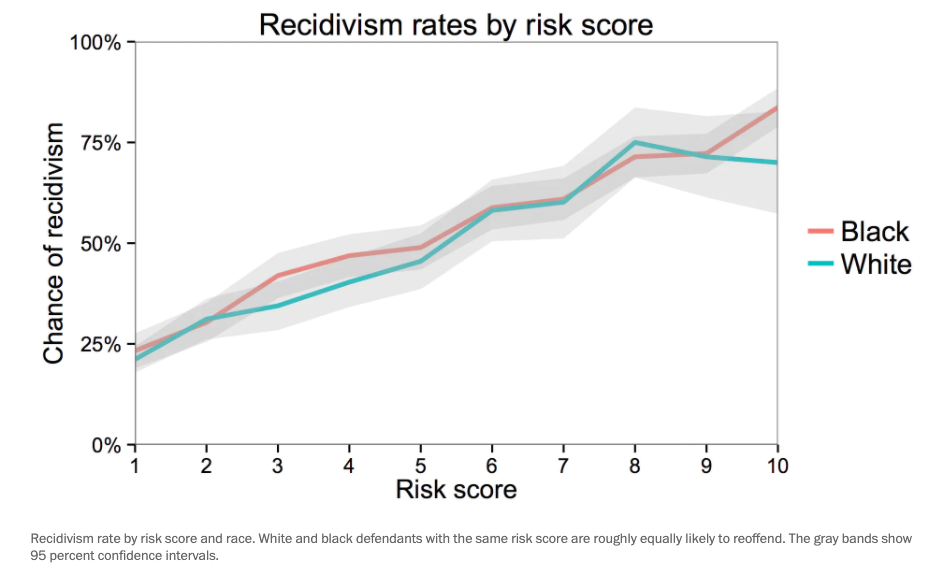

In [138]:
#Groupby is not needed, since seaborn can aggregate data 

## perform groupby
# df_rates = df.groupby(["race", "decile_score"])[["is_recid"]].mean()
# df_rates = df_rates.reset_index()
  
# # plot 
# sns.lineplot(x="decile_score",
#            y="is_recid",
#            hue="race",
#            data=df_rates, ci="sd")

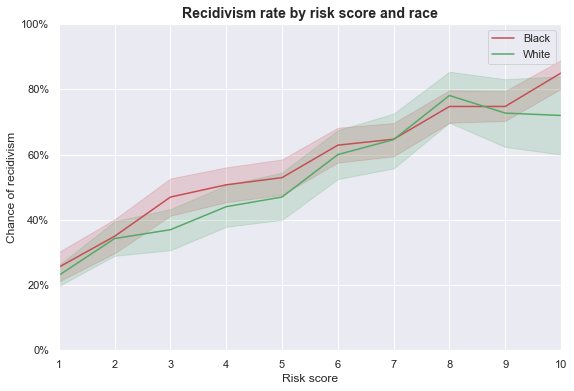

In [139]:
from  matplotlib.ticker import PercentFormatter

fig1, ax = plt.subplots(figsize=(9, 6))

sns.lineplot(x="decile_score",
             y="is_recid",
             hue="race",
             palette=['r', 'g'],
             ax=ax,
             data=df)

ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.set_title("Recidivism rate by risk score and race", fontsize=14, fontweight="bold")
ax.set(
    xlim=(1,10),
    ylim=(0,1),
    ylabel="Chance of recidivism",
    xlabel="Risk score"
      )
ax.legend(labels=["Black","White"]);

## Diagram: Distribution of defendants across risk categories by race
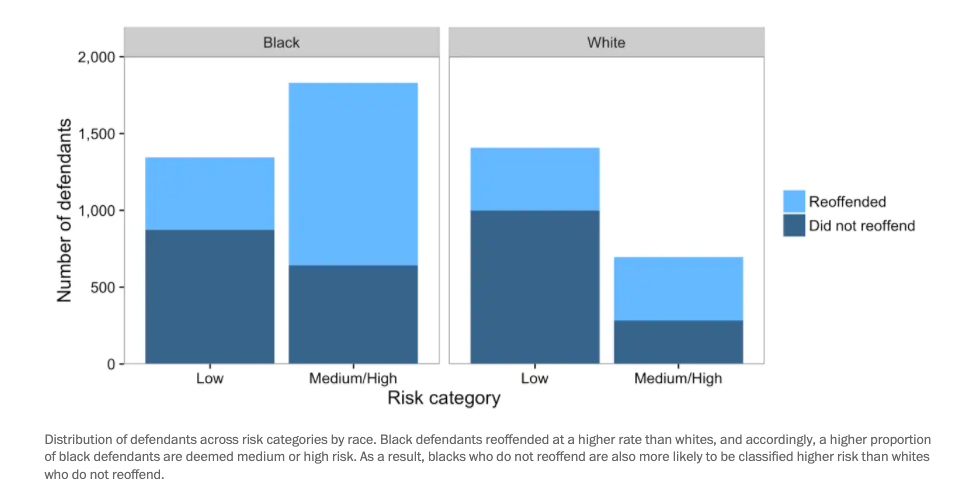

In [140]:
#Select relevant columns
df_small = df[["sex","age_cat", "race", "score_text", "two_year_recid"]].copy()

# Combine Medium and High Risk score into one category
df_small["score_text"] = df_small.score_text.apply(lambda x: "Low" if x=="Low" else "Medium/High")

In [141]:
# Filter df for white and black
df_small_b = df_small[df_small["race"]=="African-American"]
df_small_w = df_small[df_small["race"]=="Caucasian"]

In [142]:
# Create separate .groupby (for plotting reasons)
df_plot_b = df_small_b[['score_text', 'two_year_recid']].groupby(['score_text', 'two_year_recid']).size().reset_index().pivot(columns='two_year_recid', index='score_text')
df_plot_w = df_small_w[['score_text', 'two_year_recid']].groupby(['score_text', 'two_year_recid']).size().reset_index().pivot(columns='two_year_recid', index='score_text')


In [143]:
df_plot_w

0     
two_year_recid    0    1
score_text              
Low             999  408
Medium/High     282  414

In [144]:
# Create list for percentage labels within barchart (order has to be this way, due to plotting reasons)

#Black defendants
label_b_recid = [np.round(e/df_plot_b.iloc[0,:].sum()*100,1) for e in df_plot_b.iloc[0,:]]
label_b_worecid = [np.round(e/df_plot_b.iloc[1,:].sum()*100,1) for e in df_plot_b.iloc[1,:]]

labels_black = [[label_b_recid[0],label_b_worecid[0]], [label_b_recid[1],label_b_worecid[1]]]

#White defendants
label_w_recid = [np.round(e/df_plot_w.iloc[0,:].sum()*100,1) for e in df_plot_w.iloc[0,:]]
label_w_worecid = [np.round(e/df_plot_w.iloc[1,:].sum()*100,1) for e in df_plot_w.iloc[1,:]]

labels_white = [[label_w_recid[0],label_w_worecid[0]], [label_w_recid[1],label_w_worecid[1]]]

#Combined list for barplot
lables_barplot = [labels_black, labels_white]

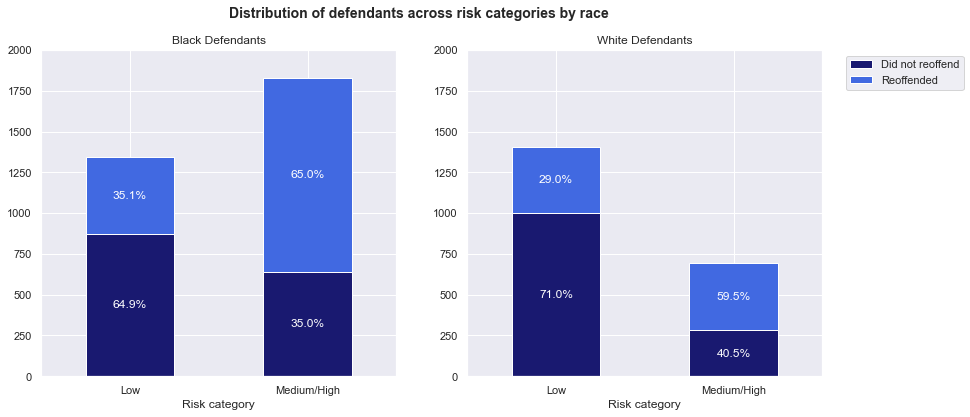

In [145]:
fig, axes = plt.subplots(1,2, figsize=(14,6))#, gridspec_kw={'width_ratios': [3,3,1]})
fig.suptitle("Distribution of defendants across risk categories by race", fontsize=14, fontweight="bold")

#Black defendants
df_plot_b.plot(kind='bar', stacked=True, ax=axes[0], color=["midnightblue", "royalblue"])
            
axes[0].set_title("Black Defendants")
axes[0].get_legend().remove()
#axes[0].legend(labels=["Did not reoffend","Reoffended"])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

#White defendants
df_plot_w.plot(kind='bar', stacked=True, ax=axes[1], color=["midnightblue", "royalblue"])
            
axes[1].set_title("White Defendants")
axes[1].get_legend().remove()
axes[1].legend(labels=["Did not reoffend","Reoffended"],bbox_to_anchor=(1.05, 1.0), loc='upper left')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

#Set labels within bar plot 
for j in range(2):
    labels = lables_barplot[j]
    for i, container in enumerate(axes[j].containers):
        axes[j].bar_label(container, labels=['%.1f%%' %e for e in labels[i]], label_type='center', color='w')

plt.setp(axes, ylim=(0,2000), xlabel="Risk category");
#plt.legend(labels=["Did not reoffend","Reoffended"])
    